# Transportation Delay Modeling

The goal of the notebook is to develop a model for **estimating the probability distribution of transportation delays** using the *istdaten* dataset. This dataset contains historical data on transportation arrivals and departures, including delays. The model takes into account the type of transportation and the time at which the transport is taken. By analyzing historical data on transportation delays, the notebook can learn patterns and trends in delay times, and use this information to generate probability distributions that can be used to **predict future delays**. However, in cases where a stop ID is present in the *allstops* dataset but not in the *istdaten* dataset, we infer the probability distribution by looking at similar conditions (time and type of transport).

## Initialize the environment

In [2]:
%load_ext sparkmagic.magics

Cleaning up livy sessions on exit is enabled


In [3]:
import os
from IPython import get_ipython
username = os.environ['RENKU_USERNAME']
server = "http://iccluster044.iccluster.epfl.ch:8998"

# set the application name as "<your_gaspar_id>-final-project"
get_ipython().run_cell_magic(
    'spark',
    line='config', 
    cell="""{{ "name": "{0}-final-project", "executorMemory": "4G", "executorCores": 4, "numExecutors": 10, "driverMemory": "4G" }}""".format(username)
)

In [4]:
get_ipython().run_line_magic(
    "spark", f"""add -s {username}-final-project -l python -u {server} -k"""
)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
5561,application_1680948035106_5062,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [5]:
%%spark

print('We are using Spark %s' % spark.version)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We are using Spark 2.4.8.7.1.8.0-801

In [6]:
%%spark

# Imports
import pyspark.sql.functions as F
from pyspark.sql import Row
from math import radians, cos, sin, asin, sqrt, floor
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, ArrayType, FloatType
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.stats import norm
from scipy.optimize import curve_fit
import numpy as np

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a critical step in modeling the delays of a system such as Swiss trains. EDA can help to identify patterns and relationships within the delay data that may provide insights into the main causes of variation in the delays. By exploring the data visually and statistically, EDA can help to reveal hidden insights, highlight important variables, and suggest potential modeling approaches. To perform the exploratory data analysis, we will use a sample of the data in order to reduce the computational load and speed up the analysis.

In [7]:
%%spark

# Path to the ORC data
path_istdaten = "/data/sbb/part_orc/istdaten"
path_allstops = "/data/sbb/orc/allstops"

# Loading ORC data into a Spark dataframe
df_istdaten = spark.read.orc(path_istdaten)
df_allstops = spark.read.orc(path_allstops)

# get only a sample of the data
df_istdaten = df_istdaten.sample(0.01, 0)
df_allstops = df_allstops.sample(0.01, 0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

During our analysis, we will use the name of the stops in order to distinguish them. However, it is interesting to note that some stops share the same name even though they do not share the same ID. 

In [8]:
%%spark

nb_stops = df_allstops.count()
nb_stop_names = df_allstops.groupby("stop_name").count().count()
print("We have {} different stop IDs for only {} different names.".format(nb_stops, nb_stop_names))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We have 486 different stop IDs for only 481 different names.

In our dataframe "istdaten" some stops are way more represented than others:

In [9]:
%%spark

joined_df = df_allstops.join(df_istdaten, df_allstops.stop_name == df_istdaten.haltestellen_name)
stop_delays_count_df = joined_df.groupby("stop_name").count()

stop_delays_count_df.sort("count", ascending=True).show(n=5, truncate=False, vertical=False)
stop_delays_count_df.sort("count", ascending=False).show(n=5, truncate=False, vertical=False)
nb_stops_with_at_least_1_delay = stop_delays_count_df.count()

print("""We have only {} stops with at least 1 row in istdaten corresponding to this stop name. 
Some have only 1 row and other have up to {} different departure and arrival times."""
      .format(nb_stops_with_at_least_1_delay, stop_delays_count_df.sort("count", ascending=False).first()[1])) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+-----+
|stop_name                 |count|
+--------------------------+-----+
|Auggen                    |1    |
|Dornbirn, Bahnhof         |1    |
|Meckenbeuren              |2    |
|St-Gingolph, Villa Eugénie|2    |
|Konstanz                  |2    |
+--------------------------+-----+
only showing top 5 rows

+-------------------------+-----+
|stop_name                |count|
+-------------------------+-----+
|Olten                    |45972|
|Zürich Flughafen, Bahnhof|32063|
|Thun, Bahnhof            |29748|
|Lausanne, Georgette      |19236|
|Basel SBB                |14299|
+-------------------------+-----+
only showing top 5 rows

We have only 285 stops with at least 1 row in istdaten corresponding to this stop name. 
Some have only 1 row and other have up to 45972 different departure and arrival times.

**Insights:**

From this, it is clear that not all stops in the transportation network have complete data about the departure and arrival times of the transport stopping at those stops. In some cases, there may be missing or incomplete data for certain stops. To address this issue, we need to get estimates for similar stops that have more complete data. By analyzing the data from similar stops, we can generate an estimate of the probability distribution of delays for the stops with missing or incomplete data. This allows us to make informed predictions about the expected delay times for these stops, even if we do not have complete data for them. By leveraging information from similar stops, we can improve the accuracy of our delay predictions and provide more reliable information to transportation planners and customers.

In [10]:
%%spark

# Keep only the needed information and rename
df_istdaten_clean = df_istdaten.filter((df_istdaten['ZUSATZFAHRT_TF'] == False) # We remove additional trips
                                       & (df_istdaten['DURCHFAHRT_TF'] == False) # We remove trips where the transport do not stop
                                       & (df_istdaten['FAELLT_AUS_TF'] == False)).select( # We remove failed trips 
        df_istdaten['BETRIEBSTAG'].alias('date'), 
        df_istdaten['PRODUKT_ID'].alias('transport_type'), 
        df_istdaten['HALTESTELLEN_NAME'].alias('stop_name'), 
        F.to_timestamp(df_istdaten["ANKUNFTSZEIT"], 'dd.MM.yyy HH:mm').alias("arrival_time"),
        F.to_timestamp(df_istdaten["AN_PROGNOSE"], 'dd.MM.yyyy HH:mm:ss').alias("actual_arrival_time"),
        df_istdaten['AN_PROGNOSE_STATUS'].alias('arrival_time_status'),
        F.to_timestamp(df_istdaten["ABFAHRTSZEIT"], 'dd.MM.yyy HH:mm').alias("departure_time"),
        F.to_timestamp(df_istdaten["AB_PROGNOSE"], 'dd.MM.yyyy HH:mm:ss').alias("actual_departure_time"),
        df_istdaten['AB_PROGNOSE_STATUS'].alias('departure_time_status'))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
%%spark
nb_rows = df_istdaten.count()
count_clean = df_istdaten_clean.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
%%spark
df_istdaten_clean.groupBy("arrival_time_status").count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------+
|arrival_time_status|   count|
+-------------------+--------+
|         GESCHAETZT| 2023330|
|           PROGNOSE|14562801|
|                   |  585750|
|               REAL|12191388|
|          UNBEKANNT|  389855|
+-------------------+--------+

We have observed that the recorded time of arrival is frequently based on the forecast (PROGNOSE) or estimated (GESCHAETZT) time, rather than the actual time. As our aim is to predict future delays, we are only interested in the real delays. Therefore, we will filter the data to keep only the rows where the actual time of arrival is known.

In [13]:
%%spark

df_istdaten_clean = df_istdaten_clean.filter(df_istdaten_clean['arrival_time_status'] == "REAL")
count_real_arrival = df_istdaten_clean.count()

print("""We lose approximately {:.2f}% of the data doing so but the data lost are of no interest 
in order to model the probability distribution of the delays.""".format((1-(count_real_arrival/count_clean))*100))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We lose approximately 59.02% of the data doing so but the data lost are of no interest 
in order to model the probability distribution of the delays.

We have also observed that in some cases, although the actual departure and arrival times are both recorded as "REAL", the departure time may be earlier than the arrival time. Clearly, this is not feasible as a mode of transport cannot leave a station before arriving at it. We consider such records as erroneous and therefore exclude them from our analysis.

In [14]:
%%spark

df_istdaten_clean = df_istdaten_clean.where((df_istdaten_clean.actual_arrival_time <= df_istdaten_clean.actual_departure_time)
                        & (df_istdaten_clean['departure_time_status'] == "REAL"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
%%spark
# We remove null values
df_istdaten_clean = df_istdaten_clean.where(df_istdaten_clean.arrival_time.isNotNull()
                                          & df_istdaten_clean.actual_arrival_time.isNotNull()
                                          & df_istdaten_clean.departure_time.isNotNull()
                                          & df_istdaten_clean.actual_departure_time.isNotNull())

df_istdaten_clean = df_istdaten_clean.filter(col("transport_type") != '')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
%%spark

def haversine_distance(lon1, lat1, lon2, lat2):
    """Compute the distance between two locations in kilometers given the latitude and longitude of both location"""
    
    # Convert latitude and longitude to radian (from degree) 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    lon_d = lon2 - lon1 
    lat_d = lat2 - lat1 
    a = sin(lat_d/2)**2 + cos(lat1) * cos(lat2) * sin(lon_d/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

zurich_lat = 47.378177
zurich_lon = 8.540192
zurich_ID = 8503000

@F.udf
def get_hour(timestamp):
    return int(timestamp.time().hour)

@F.udf
def dist_to_zurich(lon, lat):
    return haversine_distance(lon, lat, zurich_lon, zurich_lat)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
%%spark

# We filter the trips in order to keep the trips at "reasonable hours of the day, and on a typical business day"
df_istdaten_clean = df_istdaten_clean.withColumn('day_of_week', F.dayofweek(df_istdaten_clean.departure_time))
df_istdaten_clean = df_istdaten_clean.where((get_hour(df_istdaten_clean.arrival_time) >= 6)
                                          & (get_hour(df_istdaten_clean.arrival_time) <= 22)
                                          & (df_istdaten_clean.day_of_week >= 2) 
                                          & (df_istdaten_clean.day_of_week <= 6))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
%%spark

# We filter the trips in order to keep the stops in the 15km radius that are reachable from Zürich HB
stops_in_radius = df_allstops.where(dist_to_zurich(df_allstops.stop_lon, df_allstops.stop_lat) < 15)
stops_in_radius = [row.stop_name for row in stops_in_radius.select("stop_name").collect()]
df_istdaten_clean = df_istdaten_clean.where(df_istdaten_clean.stop_name.isin(stops_in_radius))
remaining_data_count = df_istdaten_clean.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
%%spark

print("There are {} different stops in a radius of 15km around Zürich's train station.".format(len(stops_in_radius)))
print("We are now left with {:.3f}% of our initial data.".format((remaining_data_count/nb_rows)*100))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 17 different stops in a radius of 15km around Zürich's train station.
We are now left with 0.045% of our initial data.

In [20]:
%%spark

# Compute the delays
df_istdaten_clean = df_istdaten_clean.withColumn('departure_delay', (F.unix_timestamp(df_istdaten_clean.actual_departure_time) - F.unix_timestamp(df_istdaten_clean.departure_time)))
df_istdaten_clean = df_istdaten_clean.withColumn('arrival_delay', (F.unix_timestamp(df_istdaten_clean.actual_arrival_time) - F.unix_timestamp(df_istdaten_clean.arrival_time)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
%%spark

# We convert the data to pandas in order to plot the delays
delays_pd = df_istdaten_clean.select('arrival_delay', 'departure_delay').toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

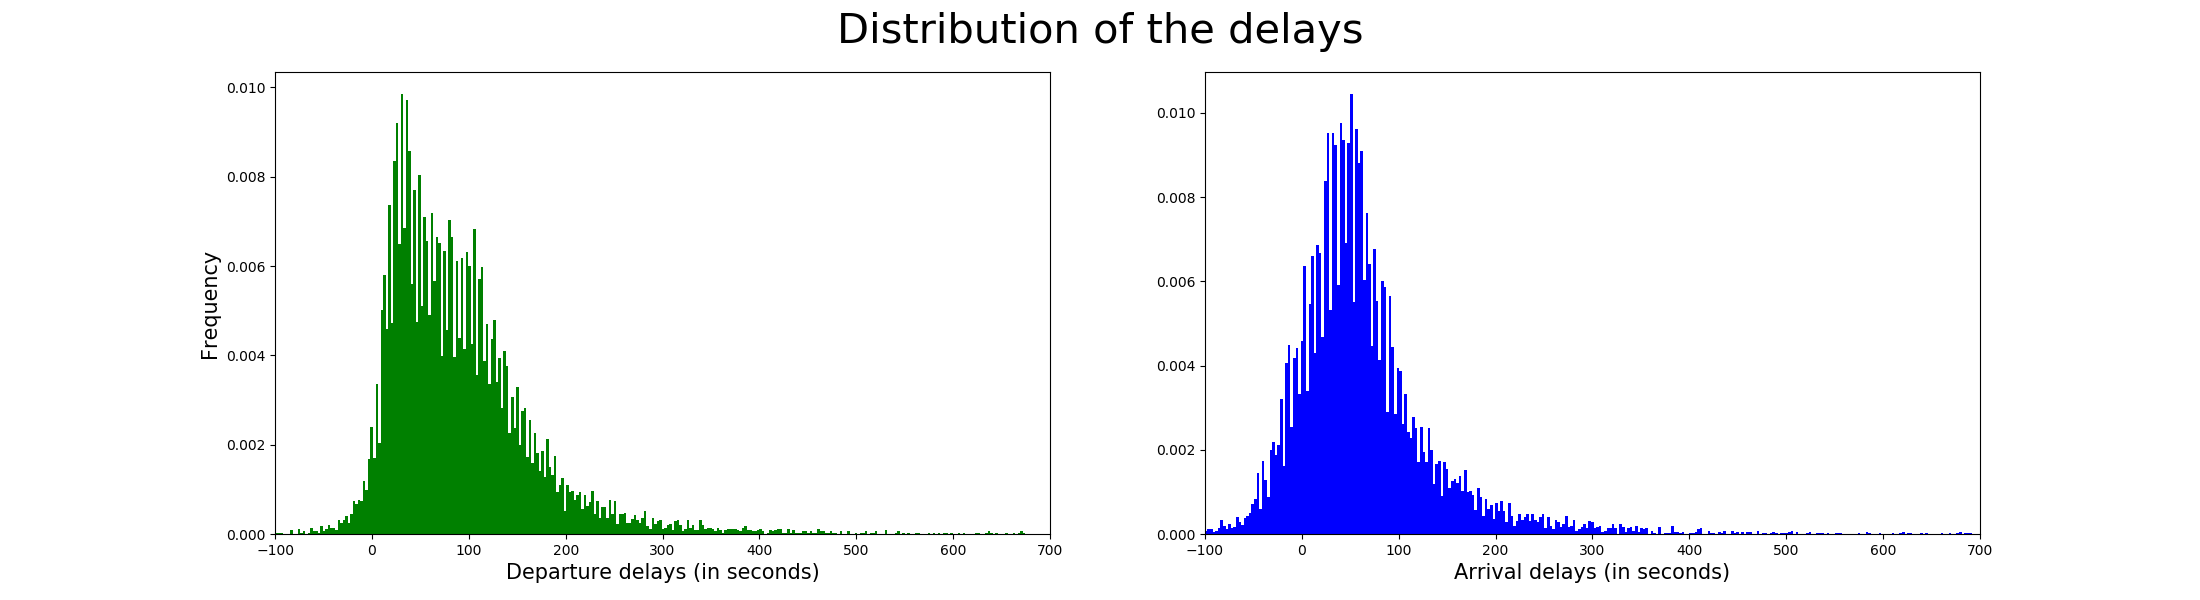

In [22]:
%%spark

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
axes[0].hist(delays_pd.departure_delay, color='g', bins=1000, density = True, stacked = False)
axes[1].hist(delays_pd.arrival_delay, color='b', bins=1000, density = True, stacked = True)

fig.suptitle('Distribution of the delays', fontsize=30)
axes[0].set_xlabel('Departure delays (in seconds)', fontsize=15)
axes[0].set_ylabel('Frequency', fontsize=15)
axes[0].set_xlim(-100, 700)
axes[1].set_xlabel('Arrival delays (in seconds)', fontsize=15)
axes[1].set_xlim(-100, 700)

plt.show()
%matplot plt

It is interesting to notice that both distribution are slightly different. The distribution of the departure delays is more sharp near 0 which makes sense because if the transport is in advance with respect to its schedule then it should wait and probably does most of the time (but some don't looking at the data). The distribution of the arrival delays resemble more to a normal distribution with a fat right tail. An arrival in advance with respect to the schedule is not a problem and this parly explain why the arrival distribution is more symmetrical.

In this project, we are **only interested in the distribution of the arrival delays** as they are the only ones that can cause a miss connection. 

#### Time-based analysis of delay data

##### Hour of the day

In [23]:
%%spark

# We compute the mean of the delays for each hour of the day
df_istdaten_clean = df_istdaten_clean.withColumn('hour', get_hour(df_istdaten_clean.arrival_time).cast(IntegerType()))
delay_by_hour = df_istdaten_clean.groupby('hour').agg(F.mean('arrival_delay').alias('mean_delay')).orderBy('hour')
delay_by_hour_p = delay_by_hour.toPandas().sort_values('hour')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

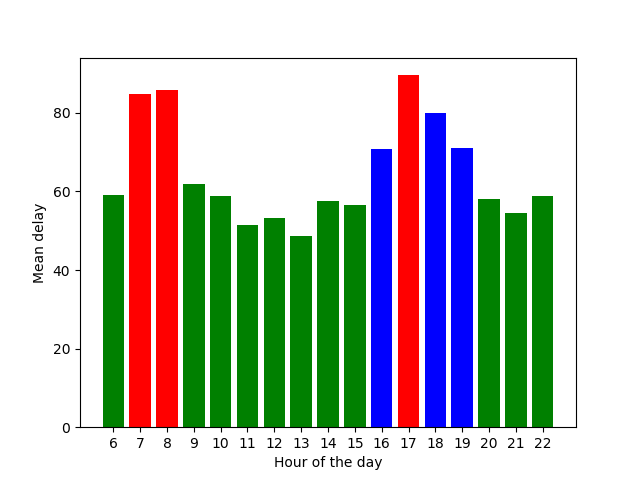

In [24]:
%%spark

# The colors are manually chosen
color_cat = ['r' if x in [7, 8, 17]
               else 'b' if x in [16, 18, 19]
               else 'g' for x in range(6, 22)]

plt.figure()
plt.bar(delay_by_hour_p['hour'], delay_by_hour_p['mean_delay'], color=color_cat)
plt.xlabel('Hour of the day')
plt.ylabel('Mean delay')
plt.xticks(range(6, 23))
plt.show()
%matplot plt

In [25]:
%%spark

@F.udf
def get_hour_cat(hour):
    hour_cat = 0
    if hour in [7, 8, 17]:
        hour_cat = 1
    elif hour in [16, 18, 19]:
        hour_cat = 2
    else:
        hour_cat = 3
    return hour_cat

df_istdaten_clean = df_istdaten_clean.withColumn('hour_cat', get_hour_cat(df_istdaten_clean.hour).cast(IntegerType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Day of the week

In [26]:
%%spark

delay_by_day = df_istdaten_clean.groupby('day_of_week') \
                                .agg(F.mean('arrival_delay') \
                                .alias('mean_delay')) \
                                .toPandas() \
                                .sort_values('day_of_week')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

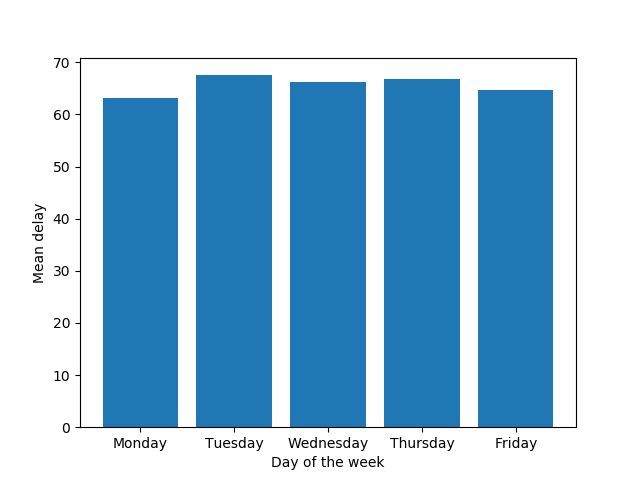

In [27]:
%%spark

plt.figure()
plt.bar(delay_by_day['day_of_week'], delay_by_day['mean_delay'])
plt.xlabel('Day of the week')
plt.ylabel('Mean delay')
plt.xticks(range(2, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.show()
%matplot plt

#### Transport-based analysis of delay data

In [28]:
%%spark

# We convert the data to pandas in order to plot the mean of the delay in function of the transport type
delay_by_transport = df_istdaten_clean.groupby('transport_type').agg(F.mean('arrival_delay').alias('mean_delay')).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

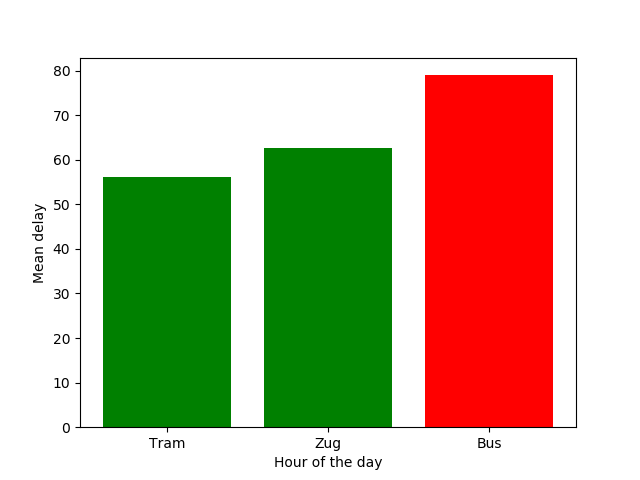

In [29]:
%%spark

color_range = ['g', 'g', 'r']

plt.figure()
plt.bar(delay_by_transport['transport_type'], delay_by_transport['mean_delay'], color=color_range)
plt.xlabel('Hour of the day')
plt.ylabel('Mean delay')
plt.show()
%matplot plt

We notice that "Tram" and "Zug" have the same mean delay and that "Bus" has a significant bigger mean. It is easily explainable by the fact that "Tram" and "Zug" are not mixed with the cars and then less affected by traffic.

In [30]:
%%spark

@F.udf
def get_transport_cat(transport_type):
    transport_cat = 0
    if transport_type == 'Tram' or transport_type == 'Zug':
        transport_cat = 1
    elif transport_type == 'Bus':
        transport_cat = 2
    return transport_cat

df_istdaten_clean = df_istdaten_clean.withColumn('transport_cat', get_transport_cat(df_istdaten_clean.transport_type).cast(IntegerType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Insights:**

Some parameters significantly affect the distribution of the delays. For simplicity, we only plotted the effect of the parameters on the first moment of the distribution. We learned that the type of transport and the hour of the day are some important parameters to take into account when modeling the probability distribution. We will use those information in order to model more specific distributions.

In [31]:
%%spark

df_istdaten_clean = df_istdaten_clean.withColumn('category', F.concat(df_istdaten_clean.transport_cat, df_istdaten_clean.hour_cat))
df_istdaten_clean.groupBy('category').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----+
|category|count|
+--------+-----+
|      11| 1943|
|      22|  706|
|      23| 1667|
|      12| 1922|
|      13| 6662|
|      21|  735|
+--------+-----+

In [33]:
%%spark

# We convert the data to pandas in order to plot the delay distributions
df_panda = df_istdaten_clean.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

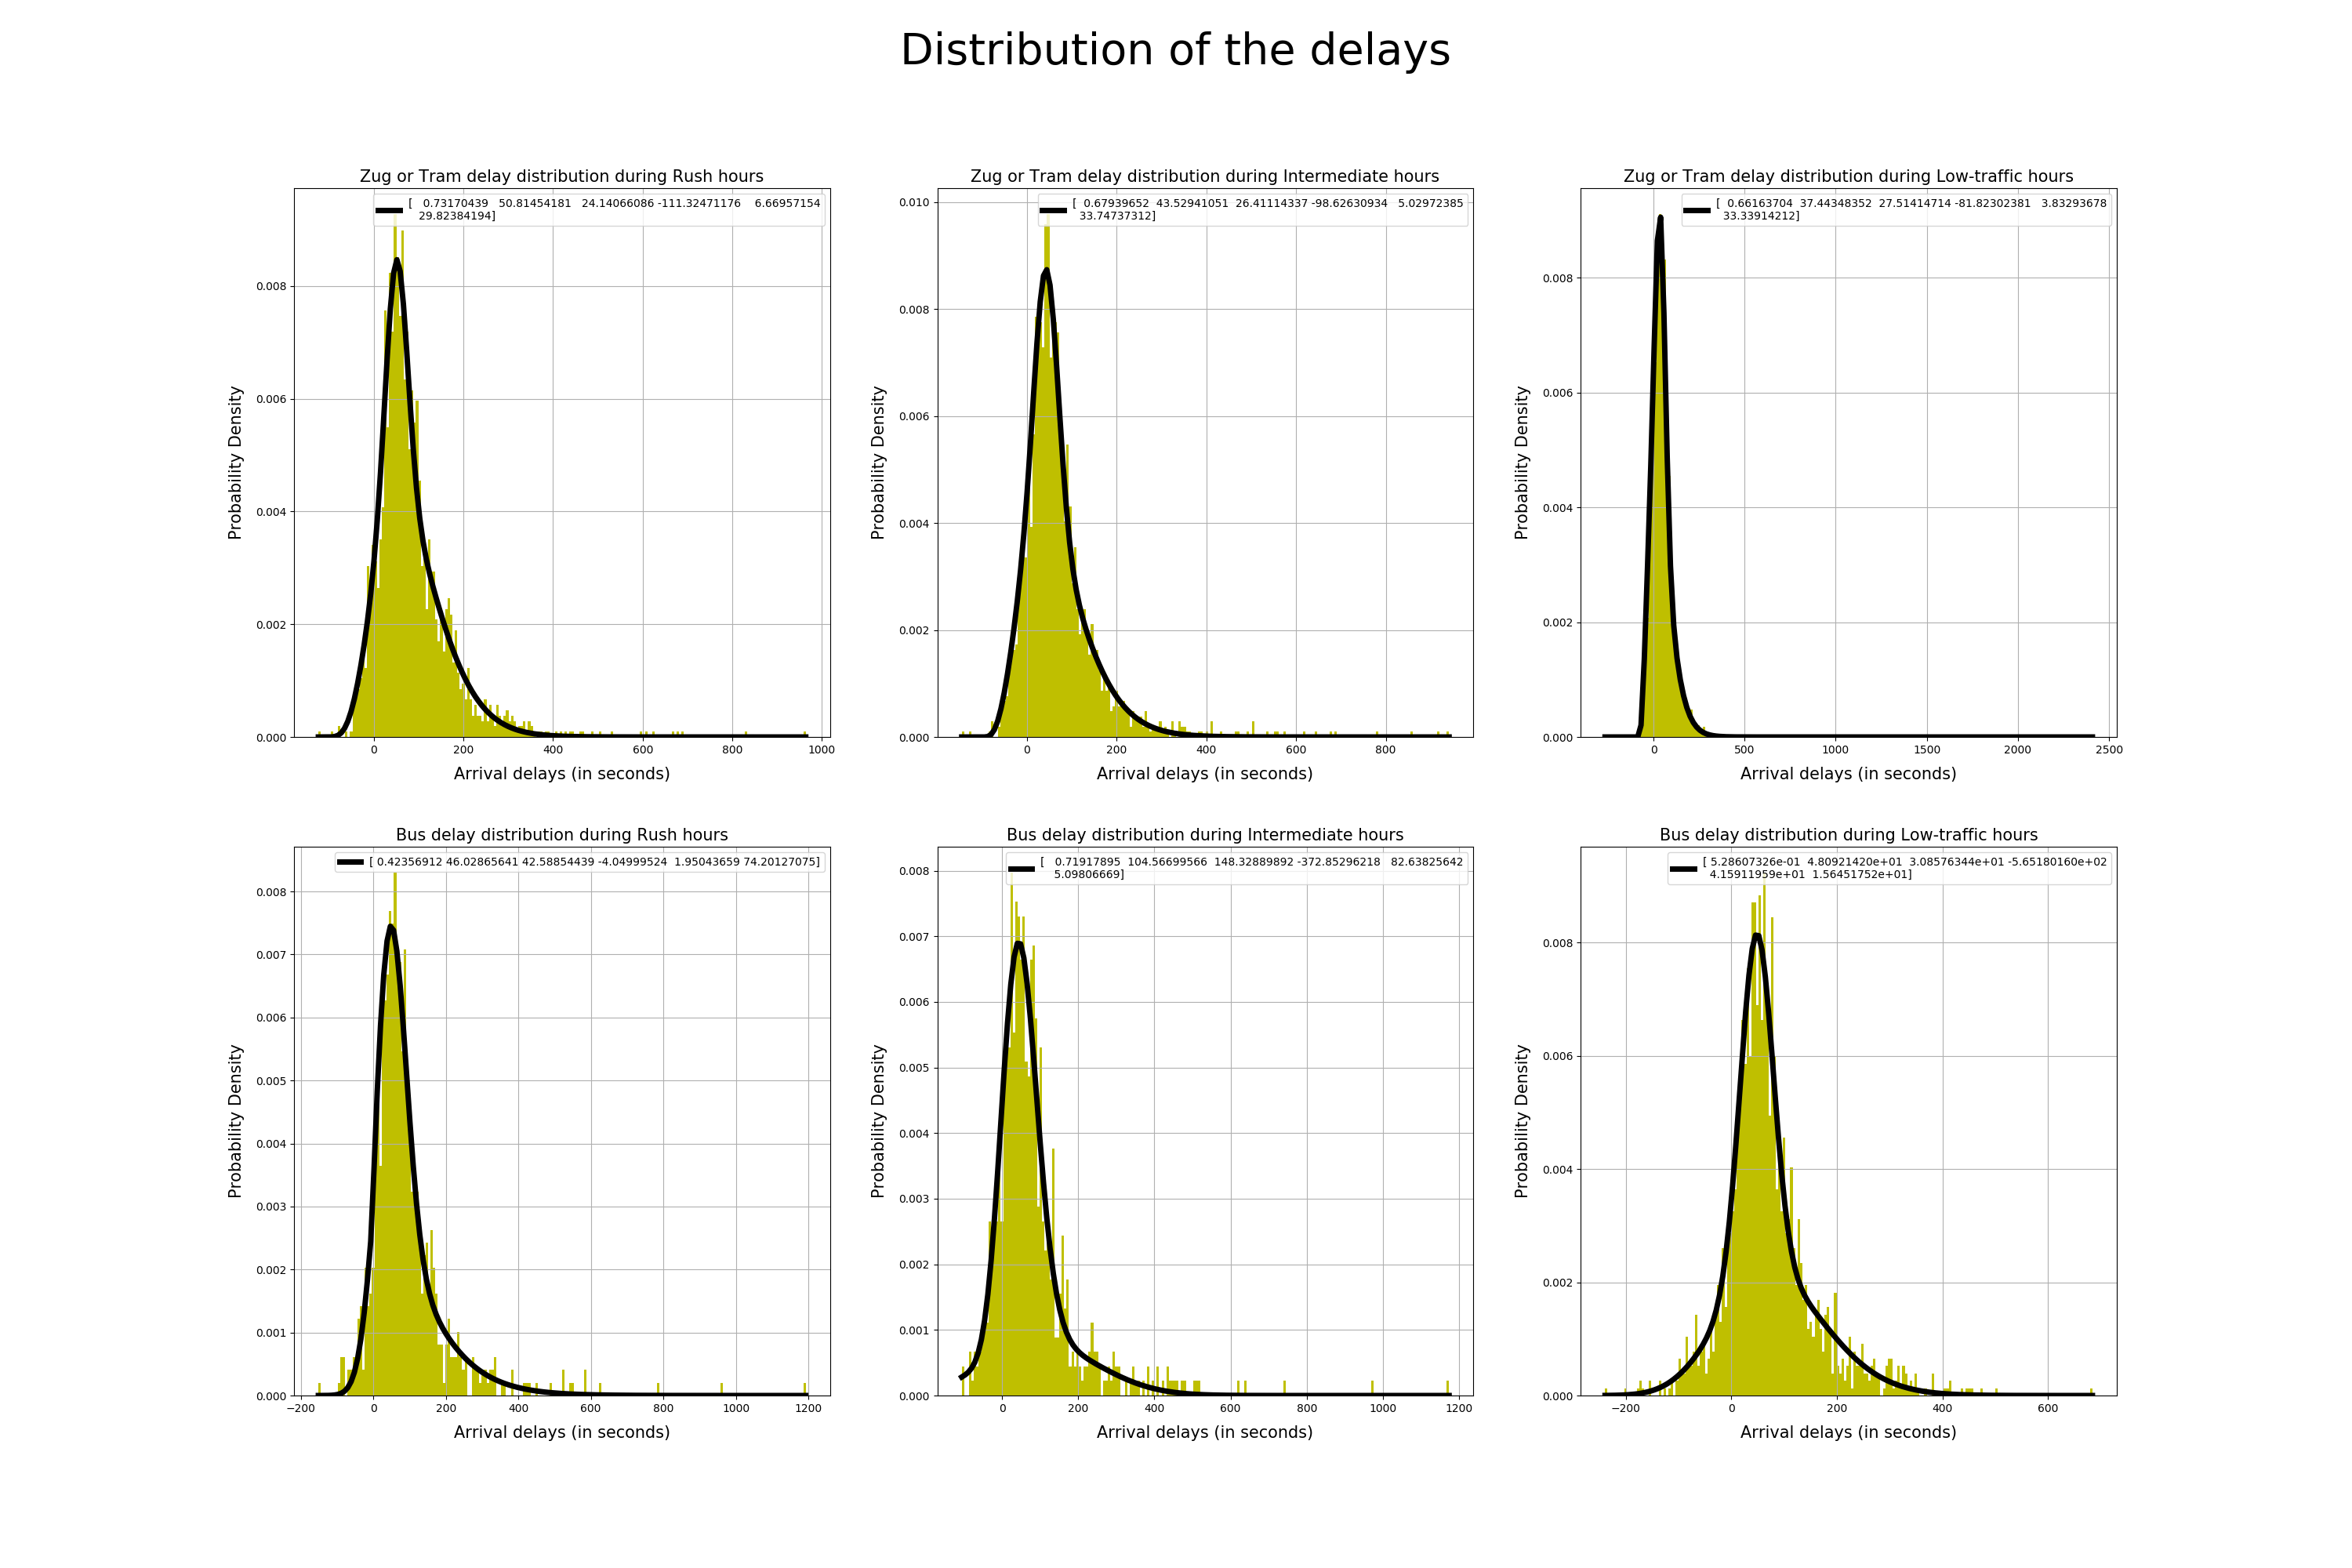

In [34]:
%%spark

def mixture(x, w, mu, sigma, xm, b, scale):
    return w * gamma.pdf(x, b, loc=xm, scale=scale) + (1-w) * norm.pdf(x, loc=mu, scale=sigma)

types_of_transport = {1:"Zug or Tram", 2:"Bus"}
time_of_day = {1:"Rush hours", 2:"Intermediate hours", 3:"Low-traffic hours"}
gamma_params = {}

fig, axes = plt.subplots(nrows=len(types_of_transport), ncols=len(time_of_day), figsize=(30,20))

# Plot the distribution of the different groups
axe_x = 0
axe_y = 0
for tt in types_of_transport.keys() :
    for td in time_of_day.keys() :

        # Name of the group
        name = types_of_transport[tt] + " delay distribution during " + time_of_day[td]

        # Filter the relevant delays
        arrival_delays = df_panda[(df_panda.transport_cat==tt) & (df_panda.hour_cat==td)].arrival_delay
        y, x = np.histogram(arrival_delays, density=True, bins = 200)
        
        # Fit the probability distribution
        p_init = [0.5, arrival_delays.mean(), arrival_delays.std(), -100, 2, 100]
        params, _ = curve_fit(mixture, x[:-1], y, p0=p_init, maxfev = 10000)

        # Plot histogram
        axes[axe_y][axe_x].hist(arrival_delays, color='y', bins=200, density = True, stacked = True)

        # Plot the model distribution
        x = np.linspace(arrival_delays.min(), arrival_delays.max(), 150)            
        axes[axe_y][axe_x].plot(x, mixture(x, *params), color='k', linewidth=5, label=str(params))

        axes[axe_y][axe_x].legend()
        axes[axe_y][axe_x].grid(True)

        axes[axe_y][axe_x].set_xlabel("Arrival delays (in seconds)", fontsize=15, labelpad=10)
        axes[axe_y][axe_x].set_ylabel("Probability Density", fontsize=15, labelpad=10)    
        axes[axe_y][axe_x].set_title(name, fontsize=15)

        # Increment the plot index
        axe_x += 1
        if (axe_x % len(time_of_day) == 0):
            axe_x = 0
            axe_y += 1
                
fig.suptitle('Distribution of the delays', fontsize=40)

plt.show()
%matplot plt

## Modeling of the delays

Now that we have gain some insights into the data, we will find the parameters of the distribution for each tuple (stop_name, time_of_day, transport_type). If we have enough data, we will only use the data of the tuple in order to model the distribution. If not enough data are available, we will use the data of (time_of_day, transport_type) and assume that the stop is not too different than the others.

In [35]:
%%spark

# Path to the ORC data
path_istdaten = "/data/sbb/part_orc/istdaten"
path_allstops = "/data/sbb/orc/allstops"

# Loading ORC data into a Spark dataframe
df_istdaten = spark.read.orc(path_istdaten)
df_allstops = spark.read.orc(path_allstops)

# get only a sample of the data
#df_istdaten = df_istdaten.sample(0.1, 0)
#df_allstops = df_allstops.sample(0.1, 0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
%%spark

# Keep only the needed information and rename
df_istdaten_clean = df_istdaten.filter((df_istdaten['ZUSATZFAHRT_TF'] == False) # We remove additional trips
                                       & (df_istdaten['DURCHFAHRT_TF'] == False) # We remove trips where the transport do not stop
                                       & (df_istdaten['FAELLT_AUS_TF'] == False)).select( # We remove failed trips 
        df_istdaten['BETRIEBSTAG'].alias('date'), 
        df_istdaten['PRODUKT_ID'].alias('transport_type'), 
        df_istdaten['HALTESTELLEN_NAME'].alias('stop_name'), 
        F.to_timestamp(df_istdaten["ANKUNFTSZEIT"], 'dd.MM.yyy HH:mm').alias("arrival_time"),
        F.to_timestamp(df_istdaten["AN_PROGNOSE"], 'dd.MM.yyyy HH:mm:ss').alias("actual_arrival_time"),
        df_istdaten['AN_PROGNOSE_STATUS'].alias('arrival_time_status'),
        F.to_timestamp(df_istdaten["ABFAHRTSZEIT"], 'dd.MM.yyy HH:mm').alias("departure_time"),
        F.to_timestamp(df_istdaten["AB_PROGNOSE"], 'dd.MM.yyyy HH:mm:ss').alias("actual_departure_time"),
        df_istdaten['AB_PROGNOSE_STATUS'].alias('departure_time_status'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
%%spark

# We perform the exact same processing as before

df_istdaten_clean = df_istdaten_clean.filter(df_istdaten_clean['arrival_time_status'] == "REAL")
df_istdaten_clean = df_istdaten_clean.where((df_istdaten_clean.actual_arrival_time <= df_istdaten_clean.actual_departure_time)
                        & (df_istdaten_clean['departure_time_status'] == "REAL"))

# We remove the null values
df_istdaten_clean = df_istdaten_clean.where(df_istdaten_clean.arrival_time.isNotNull()
                                          & df_istdaten_clean.actual_arrival_time.isNotNull()
                                          & df_istdaten_clean.departure_time.isNotNull()
                                          & df_istdaten_clean.actual_departure_time.isNotNull())

df_istdaten_clean = df_istdaten_clean.filter(col("transport_type") != '')

# We filter the trips in order to keep the trips at "reasonable hours of the day, and on a typical business day"
df_istdaten_clean = df_istdaten_clean.withColumn('day_of_week', F.dayofweek(df_istdaten_clean.departure_time))
df_istdaten_clean = df_istdaten_clean.where((get_hour(df_istdaten_clean.arrival_time) >= 6)
                                          & (get_hour(df_istdaten_clean.arrival_time) <= 22)
                                          & (df_istdaten_clean.day_of_week >= 2) 
                                          & (df_istdaten_clean.day_of_week <= 6))

# We filter the trips in order to keep the stops in the 20km radius that are reachable from Zürich HB
stops_in_radius = df_allstops.where(dist_to_zurich(df_allstops.stop_lon, df_allstops.stop_lat) < 20)
stops_in_radius = [row.stop_name for row in stops_in_radius.select("stop_name").collect()]
df_istdaten_clean = df_istdaten_clean.where(df_istdaten_clean.stop_name.isin(stops_in_radius))

# We compute the delays
df_istdaten_clean = df_istdaten_clean.withColumn('departure_delay', (F.unix_timestamp(df_istdaten_clean.actual_departure_time) - F.unix_timestamp(df_istdaten_clean.departure_time)))
df_istdaten_clean = df_istdaten_clean.withColumn('arrival_delay', (F.unix_timestamp(df_istdaten_clean.actual_arrival_time) - F.unix_timestamp(df_istdaten_clean.arrival_time)))

# We create label the data with the different categories
df_istdaten_clean = df_istdaten_clean.withColumn('hour', get_hour(df_istdaten_clean.arrival_time).cast(IntegerType()))
df_istdaten_clean = df_istdaten_clean.withColumn('hour_cat', get_hour_cat(df_istdaten_clean.hour).cast(IntegerType()))
df_istdaten_clean = df_istdaten_clean.withColumn('transport_cat', get_transport_cat(df_istdaten_clean.transport_type).cast(IntegerType()))
df_istdaten_clean = df_istdaten_clean.withColumn('category', F.concat(df_istdaten_clean.transport_cat, df_istdaten_clean.hour_cat)).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
%%spark

df_istdaten_clean.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

104967416

In [39]:
%%spark

all_stops_in_radius = df_allstops.where(dist_to_zurich(df_allstops.stop_lon, df_allstops.stop_lat) < 20).select('stop_name').distinct()
hour_cats = df_istdaten_clean.select('hour_cat').distinct()
transport_cats = df_istdaten_clean.select('transport_cat').distinct()

all_possibilities = hour_cats.crossJoin(transport_cats).crossJoin(all_stops_in_radius)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
%%spark

df_joined = (df_istdaten_clean.join(all_possibilities, ['transport_cat', 'hour_cat', 'stop_name'], how='right')).cache()
df_joined.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

104981668

In [45]:
def mixture(x, w, mu, sigma, xm, b, scale):
    return w * gamma.pdf(x, b, loc=xm, scale=scale) + (1-w) * norm.pdf(x, loc=mu, scale=sigma)

In [46]:
%%spark

@F.udf(returnType=ArrayType(FloatType(), False))
def compute_distribution(arrival_delays, hour_cat, transport_cat):
    if (len(arrival_delays) > 500):
        y, x = np.histogram(arrival_delays, density=True, bins = 10000)
        
        m = np.average(arrival_delays)
        std = np.std(arrival_delays)
        
        # Fit the probability distribution
        p_init = [0.5, m/2, std, -100, 2, 100]
        bounds = ([0.3, 5, 15, -150, 1.5, 30], [0.9, 70, 150, 0, 5, 120])
        try:
            params, _ = curve_fit(mixture, x[:-1], y, p0=p_init, maxfev=5000)
        except:
            return only_cat_pd[(only_cat_pd['hour_cat'] == hour_cat) & (only_cat_pd['transport_cat'] == transport_cat)].param.values[0]
        result = [float(x) for x in params]
        return result
    else:
        return only_cat_pd[(only_cat_pd['hour_cat'] == hour_cat) & (only_cat_pd['transport_cat'] == transport_cat)].param.values[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
%%spark

only_cat_pd = df_istdaten_clean.sample(0.7).groupBy('hour_cat', 'transport_cat').agg(compute_distribution(F.collect_list('arrival_delay'), 'hour_cat', 'transport_cat').alias('param')).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
%%spark

@F.udf(returnType=ArrayType(FloatType(), False))
def compute_distribution(arrival_delays, hour_cat, transport_cat):
    if (len(arrival_delays) > 500):
        y, x = np.histogram(arrival_delays, density=True, bins = 20000)
        
        m = np.average(arrival_delays)
        std = np.std(arrival_delays)
        
        # Fit the probability distribution
        p_init = [0.5, m/2, std, -100, 2, 100]
        bounds = ([0.3, 5, 15, -150, 1.5, 30], [0.9, 70, 150, 0, 5, 120])
        try:
            params, _ = curve_fit(mixture, x[:-1], y, p0=p_init, maxfev=10000)
        except:
            return only_cat_pd[(only_cat_pd['hour_cat'] == hour_cat) & (only_cat_pd['transport_cat'] == transport_cat)].param.values[0]
        
        result = [float(x) for x in params]
        return result
    else:
        return only_cat_pd[(only_cat_pd['hour_cat'] == hour_cat) & (only_cat_pd['transport_cat'] == transport_cat)].param.values[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
%%spark

df_with_param = df_joined.groupBy('stop_name', 'hour_cat', 'transport_cat').agg(compute_distribution(F.collect_list('arrival_delay'), 'hour_cat', 'transport_cat').alias('param')).cache()
df_with_param.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20376

# Export the data:

In [59]:
%%spark

OUTPUT_PATH = '../rjaccard/final/data/clean/'
df_with_param.write.format("parquet").mode("overwrite").option("header", "true").save(OUTPUT_PATH + 'delays.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#%spark cleanup